# MLflow Multi-Label Classification Validation Report

This notebook automatically
1. connects to MLflow;
2. grabs the **latest** run in the experiment *MultilabelPhotoTagPipeline* (fallback = *Default* experiment);
3. downloads metrics & artifacts; and
4. visualises them 👉 precision / recall / F1 per label, confusion matrix, ROC curve (micro-average), loss curves.


In [18]:
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
import pandas as pd, numpy as np, json, os, matplotlib.pyplot as plt, seaborn as sns

mlflow.set_tracking_uri("file:///workspaces/MultilabelPhotoTag_Pipeline_MKlas/mlruns")

EXPERIMENT_NAME = "photo-tagger-experiment" #"MultilabelPhotoTagPipeline"  # edit if needed
client = MlflowClient()
exp = client.get_experiment_by_name(EXPERIMENT_NAME) or client.get_experiment_by_name("Default")
runs = client.search_runs([exp.experiment_id], run_view_type=ViewType.ACTIVE_ONLY,
                          order_by=["attributes.start_time DESC"], max_results=1)
if not runs:
    raise RuntimeError(f"No runs in experiment {exp.name}.")
run = runs[0]
run_id = run.info.run_id
print("Using run_id:", run_id)

Using run_id: c92291ab1e934c688b4528b9fcbc26fc


In [19]:
# ---------- 1  Classification metrics ----------
report_path = client.download_artifacts(run_id, "classification_report.json", ".")
report = json.load(open(report_path))
metrics_df = pd.DataFrame(report).T
metrics_df.index.name = "Label"
display(metrics_df)

,precision,recall,f1-score,support
Label,,,,
0,0.600000,0.808989,0.688995,89.0
1,0.000000,0.000000,0.000000,4.0
2,0.000000,0.000000,0.000000,16.0
3,0.000000,0.000000,0.000000,6.0
4,0.000000,0.000000,0.000000,7.0
5,0.000000,0.000000,0.000000,4.0
micro avg,0.585366,0.571429,0.578313,126.0
macro avg,0.100000,0.134831,0.114833,126.0
weighted avg,0.423810,0.571429,0.486671,126.0


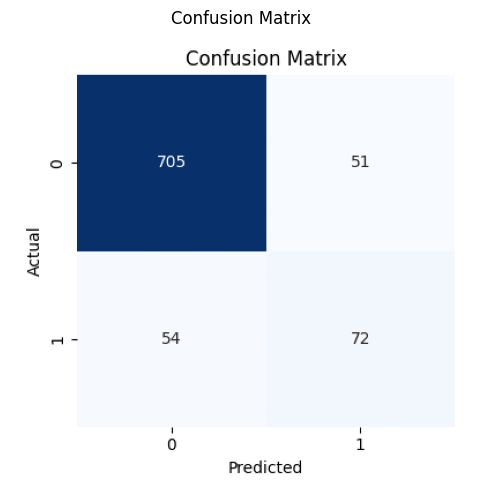

In [20]:
# ---------- 2  Confusion matrix heat-map ----------
try:
    cm_path = client.download_artifacts(run_id, "confusion_matrix.png", ".")
    img = plt.imread(cm_path)
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Confusion Matrix")
    plt.show()
except Exception as e:
    print("Confusion matrix not logged:", e)

/tmp/ipykernel_6238/1897032438.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_score = np.trapz(tpr, fpr)


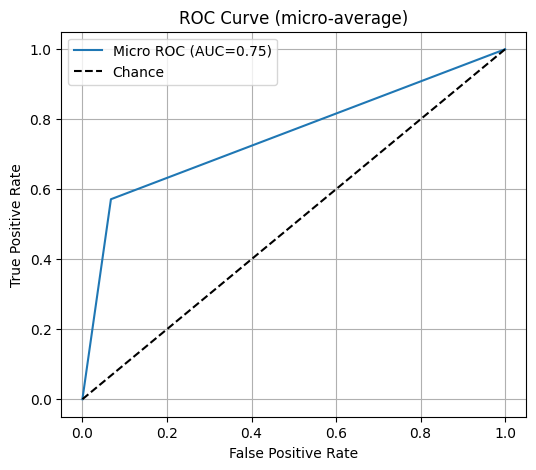

In [21]:
# ---------- 3  ROC curve (micro-average) ----------
try:
    roc_path = client.download_artifacts(run_id, "roc_curve.json", ".")
    roc_data = json.load(open(roc_path))
    fpr, tpr = np.array(roc_data["fpr"]), np.array(roc_data["tpr"])
    auc_score = np.trapz(tpr, fpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"Micro ROC (AUC={auc_score:.2f})")
    plt.plot([0,1],[0,1],'k--', label="Chance")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (micro-average)")
    plt.legend(); plt.grid(True); plt.show()
except Exception as e:
    print("ROC curve not logged:", e)

In [22]:
# ---------- 4  Loss curves ----------
try:
    hist_path = client.download_artifacts(run_id, "history.json", ".")
    history = json.load(open(hist_path))
    epochs = range(1, len(history["loss"]) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["loss"], label="Train Loss")
    if "val_loss" in history:
        plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
    plt.legend(); plt.grid(True); plt.show()
except Exception as e:
    print("History not logged:", e)

History not logged: expected str, bytes or os.PathLike object, not NoneType


In [23]:
# ---------- 5  Micro / Macro / Weighted averages ----------
for avg in ("micro avg", "macro avg", "weighted avg"):
    if avg in metrics_df.index:
        display(metrics_df.loc[[avg]])

,precision,recall,f1-score,support
Label,,,,
micro avg,0.585366,0.571429,0.578313,126.0


,precision,recall,f1-score,support
Label,,,,
macro avg,0.1,0.134831,0.114833,126.0


,precision,recall,f1-score,support
Label,,,,
weighted avg,0.42381,0.571429,0.486671,126.0


In [24]:
import os
from IPython.display import HTML
from IPython import get_ipython

# Get current notebook name
try:
    # Try to get the notebook name using IPython's special variable
    notebook_path = get_ipython().kernel.shell.user_ns["__vsc_ipynb_file__"] if "__vsc_ipynb_file__" in get_ipython().kernel.shell.user_ns else None
    if not notebook_path:
        notebook_path = get_ipython().kernel.shell.user_ns.get("__notebook_source__", "")
    notebook_name = os.path.basename(notebook_path) if notebook_path else ""
except Exception:
    notebook_name = ""

# Check if the notebook name was successfully determined
if notebook_name == "":
    # Fallback method if automatic detection fails
    notebook_name = input("Enter notebook filename (with .ipynb extension): ")

# Use nbconvert to export the notebook without input cells tagged with "remove"
# Ensure the assets directory exists
assets_dir = "../assets"
os.makedirs(assets_dir, exist_ok=True)
output_html = os.path.join(assets_dir, os.path.splitext(os.path.basename(notebook_name))[0] + "_export.html")
!jupyter nbconvert --to html --TagRemovePreprocessor.remove_cell_tags='{"remove"}' "{notebook_name}" --output "{output_html}"

# Display a success message
display(
    HTML(f"<div style=padding:10px;'>" f"<h3>Export complete!</h3>" f"<p>Notebook <b>{notebook_name}</b> has been exported to HTML.</p>" f"</div>")
)

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbconvert` not found.
